In [2]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
np.random.seed(42)

In [3]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

In [4]:
X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.01, X.iloc[:, 0].max() + 0.01
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.01, X.iloc[:, 1].max() + 0.01
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [7]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))

    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bo", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "go", ms=3)
    
    bp = 99.9 #boundary percentile for axis scaling
    xmin0, xmax0 = np.percentile(X.iloc[:,0], 100-bp), np.percentile(X.iloc[:,0], bp)
    xmin1, xmax1 = np.percentile(X.iloc[:,1], 100-bp), np.percentile(X.iloc[:,1], bp)
    plt.axis([xmin0, xmax0, xmin1, xmax1])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("SVM Decision Boundary Plot", fontsize=16)
    plt.show()

In [8]:
def linear_svc_report(feature1, feature2):
    scaler = StandardScaler()
    
    eff_X = X.loc[:, [feature1, feature2]]
    eff_X_test = X_test.loc[:, [feature1, feature2]]
    eff_X_train = X_train.loc[:, [feature1, feature2]]
    
    param_grid = {'linear_svc__loss': ['hinge'], 'linear_svc__max_iter': [20000],
             'linear_svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    svm_clf = LinearSVC()
    scaled_svm_clf = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf),
    ])
    
    svm_clf_cv = GridSearchCV(scaled_svm_clf, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    
    svm_clf_cv.fit(eff_X_train, y_train)
    params_optimal = svm_clf_cv.best_params_

    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    clf = svm_clf_cv
    
    plot_boundary_clf(clf, eff_X)
    
    y_train_predicted = clf.predict(eff_X_train)
    y_test_predicted = clf.predict(eff_X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.5s finished


Optimal Hyperparameter Values:  {'linear_svc__C': 10, 'linear_svc__loss': 'hinge', 'linear_svc__max_iter': 10000}




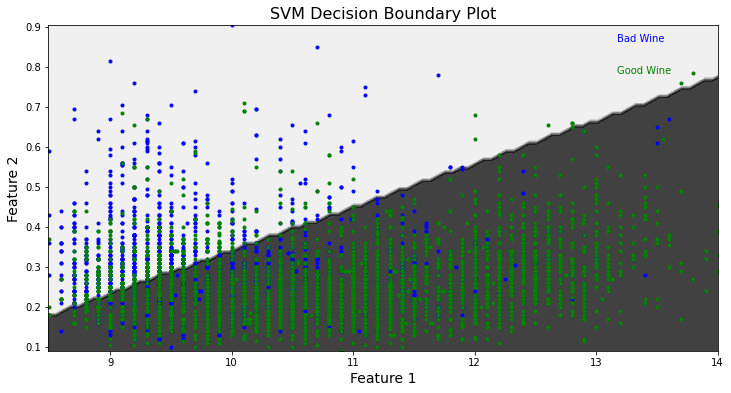


Train Accuracy:  0.7473200612557427
-----------------------------------------

Test Accuracy:  0.736734693877551

Test Confusion Matrix:
[[140 181]
 [ 77 582]]

Test Precision = 0.762779
Test Recall = 0.883156
Test F1 Score = 0.818565

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.44      0.52       321
           1       0.76      0.88      0.82       659

    accuracy                           0.74       980
   macro avg       0.70      0.66      0.67       980
weighted avg       0.72      0.74      0.72       980



In [16]:
linear_svc_report("alcohol", "volatile acidity")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s finished


Optimal Hyperparameter Values:  {'linear_svc__C': 0.0001, 'linear_svc__loss': 'hinge', 'linear_svc__max_iter': 10000}




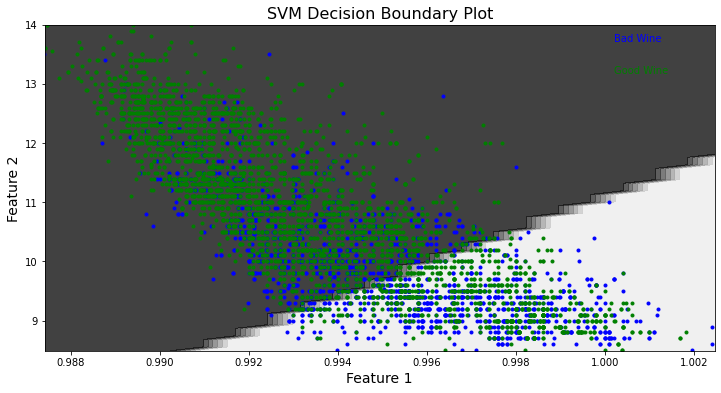


Train Accuracy:  0.6791730474732006
-----------------------------------------

Test Accuracy:  0.6795918367346939

Test Confusion Matrix:
[[160 161]
 [153 506]]

Test Precision = 0.758621
Test Recall = 0.767830
Test F1 Score = 0.763198

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       321
           1       0.76      0.77      0.76       659

    accuracy                           0.68       980
   macro avg       0.63      0.63      0.63       980
weighted avg       0.68      0.68      0.68       980



In [15]:
linear_svc_report("density", "alcohol")

In [9]:
def rbf_svc_report(feature1, feature2, C, gamma):
    
    eff_X = X.loc[:, [feature1, feature2]]
    eff_X_test = X_test.loc[:, [feature1, feature2]]
    eff_X_train = X_train.loc[:, [feature1, feature2]]
    
    param_grid = {'svc__kernel': ['rbf'], 'svc__max_iter': [20000],
                 'svc__C': C, 'svc__gamma': gamma}
    svm_clf = SVC()
    scaled_svm_clf = Pipeline([
        ("scaler", scaler),
        ("svc", svm_clf),
    ])
    
    svm_clf_cv = GridSearchCV(scaled_svm_clf, param_grid, scoring='accuracy',
                            cv=3, verbose=1, n_jobs=-1)
    
    svm_clf_cv.fit(eff_X_train, y_train)
    params_optimal = svm_clf_cv.best_params_

    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    clf = svm_clf_cv
    
    plot_boundary_clf(clf, eff_X)
    
    y_train_predicted = clf.predict(eff_X_train)
    y_test_predicted = clf.predict(eff_X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   23.3s finished


Optimal Hyperparameter Values:  {'svc__C': 1, 'svc__gamma': 1000, 'svc__kernel': 'rbf', 'svc__max_iter': 10000}




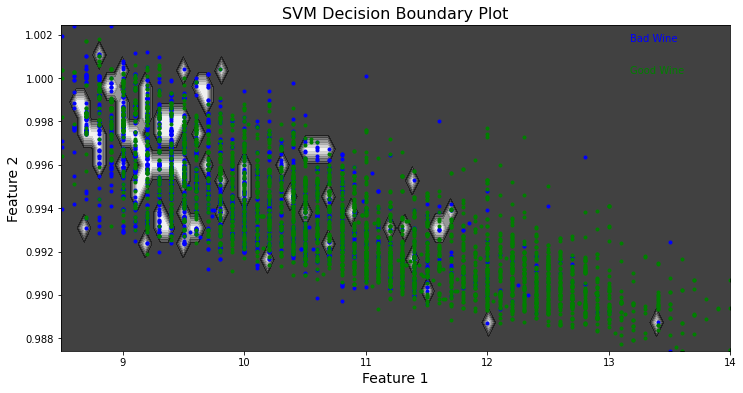


Train Accuracy:  0.8647269014803471
-----------------------------------------

Test Accuracy:  0.7295918367346939

Test Confusion Matrix:
[[143 178]
 [ 87 572]]

Test Precision = 0.762667
Test Recall = 0.867982
Test F1 Score = 0.811923

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.45      0.52       321
           1       0.76      0.87      0.81       659

    accuracy                           0.73       980
   macro avg       0.69      0.66      0.67       980
weighted avg       0.72      0.73      0.72       980



In [26]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000000]
gamma = [0.000001, 0.0001, 0.01, 0.1, 1, 10, 100, 1000]
rbf_svc_report("alcohol", "density", C, gamma)

In [10]:
def quick_parameter_plot(feature1, feature2):
    eff_X = X.loc[:, [feature1, feature2]]
    eff_X_test = X_test.loc[:, [feature1, feature2]]
    eff_X_train = X_train.loc[:, [feature1, feature2]]
    
    C_range = [10000000, 10000, 100, 10]
    gamma_range = [0.000001, 0.0001, 0.01, 0.1]
    classifiers = []
    testAccuracy = []
    for C in C_range:
        for gamma in gamma_range:
            clf = SVC(C=C, gamma=gamma)
            clf.fit(eff_X_train, y_train)
            y_test_predicted = clf.predict(eff_X_test)
            testAccuracy.append(clf.score(eff_X_test, y_test))
            classifiers.append((C, gamma, clf))
            
    plt.figure(figsize=(18, 14))
    for (k, (C, gamma, clf)) in enumerate(classifiers):
        plt.subplot(len(C_range), len(gamma_range), k + 1)
        plt.title("$\\gamma$=%.6f, C=%.0f, \nTest Accuracy = %.2f" % (gamma, C, testAccuracy[k]), size='medium')

        # visualize parameter's effect on decision function
        _ = decision_boundary_svc_class_colored(clf, eff_X, plotDistanceFromHyperplane=True)
        plt.scatter(eff_X_train.iloc[:, 0], eff_X_train.iloc[:, 1], c=y_train, s=20, cmap='autumn')
        plt.scatter(eff_X_test.iloc[:, 0], eff_X_test.iloc[:, 1], c=y_test, s=20, cmap='autumn', alpha=1.0, edgecolors="k")
        plt.xticks(())
        plt.yticks(())
        plt.axis(_)
        

In [50]:
def decision_boundary_svc_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    bp = 99.9 #boundary percentile for axis scaling
    x1min, x1max = np.percentile(X.iloc[:,0], 100-bp), np.percentile(X.iloc[:,0], bp)
    x2min, x2max = np.percentile(X.iloc[:,1], 100-bp), np.percentile(X.iloc[:,1], bp)

    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contour plot for the distance of all points from the hyperplane and the two margins
        plt.contour(x1, x2, y_decision, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='black')
        
        
        #plt.pcolormesh(x1, x2, -y_decision, cmap=plt.cm.RdBu)
        
        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()
    return [x1min, x1max, x2min, x2max]

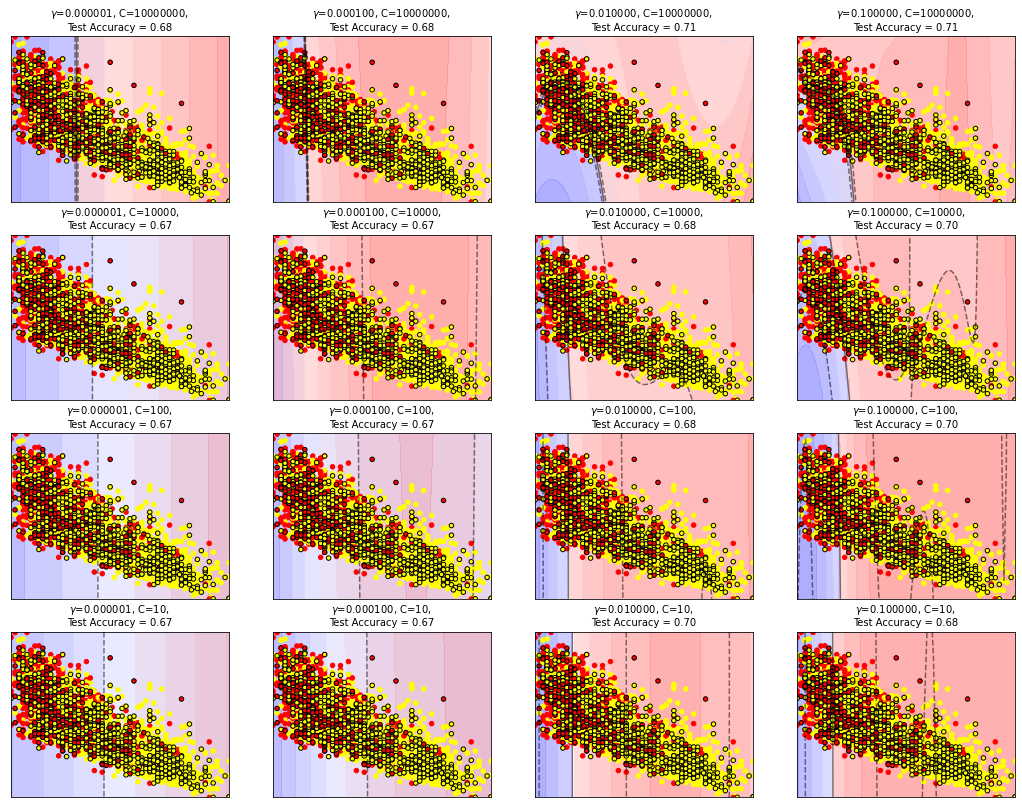

In [58]:
quick_parameter_plot("alcohol", "density")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   17.6s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 100, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}




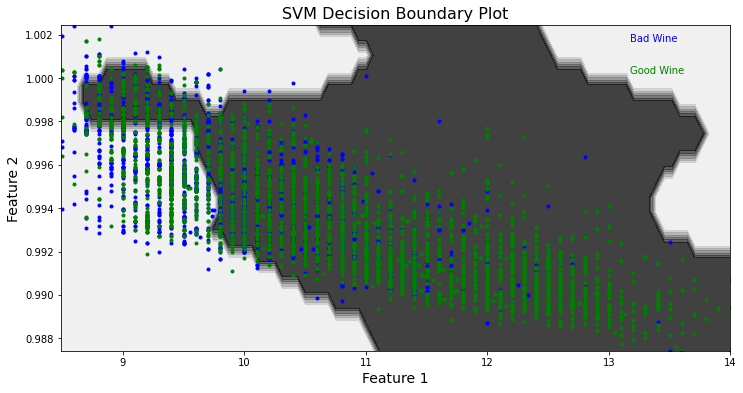


Train Accuracy:  0.7187340479836651
-----------------------------------------

Test Accuracy:  0.7183673469387755

Test Confusion Matrix:
[[157 164]
 [112 547]]

Test Precision = 0.769339
Test Recall = 0.830046
Test F1 Score = 0.798540

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       321
           1       0.77      0.83      0.80       659

    accuracy                           0.72       980
   macro avg       0.68      0.66      0.67       980
weighted avg       0.71      0.72      0.71       980



In [63]:
C = [10, 100, 1000, 10000, 100000, 1000000]
gamma = [0.000001, 0.0001, 0.001, 0.01, 0.1, 1]
rbf_svc_report("alcohol", "density", C, gamma) #course grid search

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   18.9s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Optimal Hyperparameter Values:  {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}




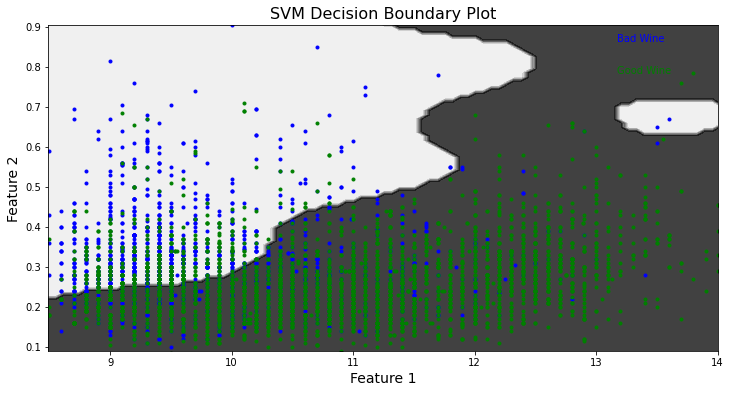


Train Accuracy:  0.7595712098009189
-----------------------------------------

Test Accuracy:  0.736734693877551

Test Confusion Matrix:
[[154 167]
 [ 91 568]]

Test Precision = 0.772789
Test Recall = 0.861912
Test F1 Score = 0.814921

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.48      0.54       321
           1       0.77      0.86      0.81       659

    accuracy                           0.74       980
   macro avg       0.70      0.67      0.68       980
weighted avg       0.73      0.74      0.73       980



In [65]:
rbf_svc_report("alcohol", "volatile acidity", C, gamma)

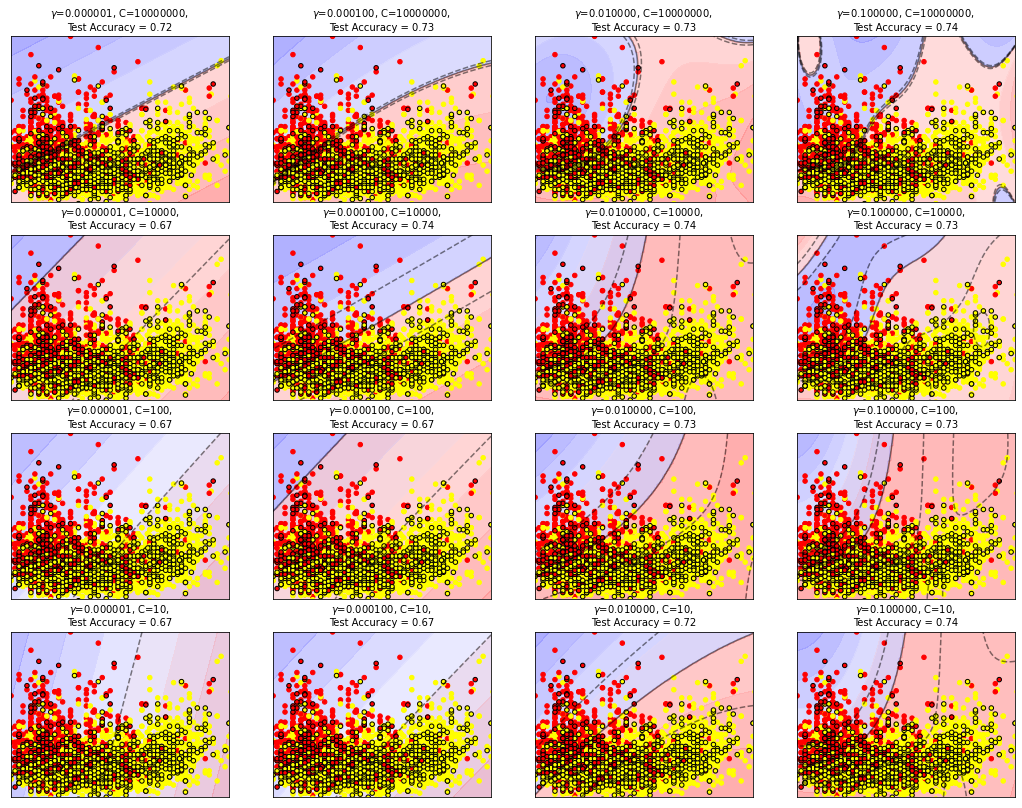

In [66]:
quick_parameter_plot("alcohol", "volatile acidity")

In [11]:
def all_feature_SVC():
    eff_X_train = X_train
    eff_X_test = X_test
    param_grid = {'svc__kernel': ['rbf'], 'svc__max_iter': [20000],
                 'svc__C': C, 'svc__gamma': gamma}
    svm_clf = SVC()
    scaled_svm_clf = Pipeline([
        ("scaler", scaler),
        ("svc", svm_clf),
    ])

    svm_clf_cv = GridSearchCV(scaled_svm_clf, param_grid, scoring='accuracy',
                            cv=5, verbose=1, n_jobs=-1)

    svm_clf_cv.fit(eff_X_train, y_train)
    params_optimal = svm_clf_cv.best_params_

    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")

    clf = svm_clf_cv

    y_train_predicted = clf.predict(eff_X_train)
    y_test_predicted = clf.predict(eff_X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))

    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))

In [78]:
C = [10, 100, 1000, 10000, 100000, 1000000]
gamma = [0.000001, 0.0001, 0.001, 0.01, 0.1, 1]
all_feature_SVC()
#still overfitting despite being able to choose a very low gamma

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   47.3s finished


Optimal Hyperparameter Values:  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.8700867789688617
-----------------------------------------

Test Accuracy:  0.7938775510204081

Test Confusion Matrix:
[[201 120]
 [ 82 577]]

Test Precision = 0.827834
Test Recall = 0.875569
Test F1 Score = 0.851032

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       321
           1       0.83      0.88      0.85       659

    accuracy                           0.79       980
   macro avg       0.77      0.75      0.76       980
weighted avg       0.79      0.79      0.79       980



In [79]:
#fine grid based on course grid results:
C = [5, 10, 15, 30, 40, 80]
gamma = np.arange(0.7, 1.3, 0.1)
all_feature_SVC()

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   53.9s finished


Optimal Hyperparameter Values:  {'svc__C': 5, 'svc__gamma': 0.7, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.99055640632976
-----------------------------------------

Test Accuracy:  0.810204081632653

Test Confusion Matrix:
[[207 114]
 [ 72 587]]

Test Precision = 0.837375
Test Recall = 0.890744
Test F1 Score = 0.863235

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       321
           1       0.84      0.89      0.86       659

    accuracy                           0.81       980
   macro avg       0.79      0.77      0.78       980
weighted avg       0.81      0.81      0.81       980



In [81]:
C = [0.5, 1, 2, 3, 4, 5]
gamma = np.arange(0.1, 1, 0.1)
all_feature_SVC()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.1min finished


Optimal Hyperparameter Values:  {'svc__C': 2, 'svc__gamma': 0.4, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.9341500765696784
-----------------------------------------

Test Accuracy:  0.7979591836734694

Test Confusion Matrix:
[[204 117]
 [ 81 578]]

Test Precision = 0.831655
Test Recall = 0.877086
Test F1 Score = 0.853767

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.67       321
           1       0.83      0.88      0.85       659

    accuracy                           0.80       980
   macro avg       0.77      0.76      0.76       980
weighted avg       0.79      0.80      0.79       980



In [13]:
C = [5, 10, 30, 80, 150, 400, 1000, 5000, 10000, 100000]
gamma = [0.7]
scaler = StandardScaler()
all_feature_SVC()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished


Optimal Hyperparameter Values:  {'svc__C': 5, 'svc__gamma': 0.7, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.99055640632976
-----------------------------------------

Test Accuracy:  0.810204081632653

Test Confusion Matrix:
[[207 114]
 [ 72 587]]

Test Precision = 0.837375
Test Recall = 0.890744
Test F1 Score = 0.863235

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       321
           1       0.84      0.89      0.86       659

    accuracy                           0.81       980
   macro avg       0.79      0.77      0.78       980
weighted avg       0.81      0.81      0.81       980



In [14]:
C = [3, 4, 5, 6, 7, 8, 9]
gamma = [0.7]
all_feature_SVC()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.8s finished


Optimal Hyperparameter Values:  {'svc__C': 3, 'svc__gamma': 0.7, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.9828994384890251
-----------------------------------------

Test Accuracy:  0.8163265306122449

Test Confusion Matrix:
[[210 111]
 [ 69 590]]

Test Precision = 0.841655
Test Recall = 0.895296
Test F1 Score = 0.867647

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       321
           1       0.84      0.90      0.87       659

    accuracy                           0.82       980
   macro avg       0.80      0.77      0.78       980
weighted avg       0.81      0.82      0.81       980



In [16]:
C = np.arange(0.25, 3, 0.25)
gamma = [0.7]
all_feature_SVC()

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   10.2s finished


Optimal Hyperparameter Values:  {'svc__C': 1.75, 'svc__gamma': 0.7, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.9693721286370597
-----------------------------------------

Test Accuracy:  0.8061224489795918

Test Confusion Matrix:
[[201 120]
 [ 70 589]]

Test Precision = 0.830748
Test Recall = 0.893778
Test F1 Score = 0.861111

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       321
           1       0.83      0.89      0.86       659

    accuracy                           0.81       980
   macro avg       0.79      0.76      0.77       980
weighted avg       0.80      0.81      0.80       980



In [17]:
C = np.arange(1.8, 4, 0.1)
gamma = [0.7]
all_feature_SVC()

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   20.4s finished


Optimal Hyperparameter Values:  {'svc__C': 1.8, 'svc__gamma': 0.7, 'svc__kernel': 'rbf', 'svc__max_iter': 20000}



Train Accuracy:  0.9696273608984176
-----------------------------------------

Test Accuracy:  0.8061224489795918

Test Confusion Matrix:
[[201 120]
 [ 70 589]]

Test Precision = 0.830748
Test Recall = 0.893778
Test F1 Score = 0.861111

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       321
           1       0.83      0.89      0.86       659

    accuracy                           0.81       980
   macro avg       0.79      0.76      0.77       980
weighted avg       0.80      0.81      0.80       980

